# Coordinate Smoothing Exploration on MoveNet Coordinate Data

For now, we will assume no packages need to be installed in Python environment. This notebook is intended to be a playground for exploring different position coordinate smoothing functions on MoveNet data.

In [3]:
import os
import sys
sys.path.append("..")
import utilsKinematics
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
from scipy.signal import find_peaks
import pandas as pd
from scipy.fft import fft, ifft

In [4]:
# User inputs
subject = "subject2"
session = "Session1"
cam = 'Cam4'

In [6]:
# Preset Path Params
trials_of_interest = ['DJ1', 'DJ2', 'DJ3', 'DJ4', 'DJ5', 'DJAsym1', 'DJAsym2', 'DJAsym3', 'DJAsym4', 'DJAsym5', 'squats1', 'squatsAsym1', 'STS1', 'STSTSweakLegs1']
trials_of_interest += ['walking1', 'walking2', 'walking3', 'walking4', 'walkingTS1', 'walkingTS2', 'walkingTS3', 'walkingTS4']

data_folder_name = str('opencap_LabValidation_withVideos_'+subject+'_VideoData_'+session)
data_folder = os.path.join(os.getcwd(), "../Data", data_folder_name)
json_data_folder_name = str('movenet_opencap_LabValidation_withVideos_'+subject+'_VideoData_'+session+'_'+cam)
json_study_prefix = str(data_folder_name+'_'+cam+'_')
json_data_folder = os.path.join(os.getcwd(), "../Data", json_data_folder_name)
avi_data_folder = str('/Users/davidspector/Home/OpenMotion/LabValidation_withVideos/'+subject+'/VideoData/'+session+'/'+cam)

model_path = os.path.join(data_folder, 'OpenSimData', 'Model')
for file in os.listdir(model_path):
    if file.endswith('.osim'):
        model_name = file[:-5]
        break

In [7]:
# Process data.
trial_names = []
kinematics, coordinates, muscle_tendon_lengths, moment_arms, center_of_mass, marker_coordinates = {}, {}, {}, {}, {}, {}
coordinates['values'], coordinates['speeds'], coordinates['accelerations'] = {}, {}, {}
center_of_mass['values'], center_of_mass['speeds'], center_of_mass['accelerations'] = {}, {}, {}

for file in os.listdir(os.path.join(data_folder, 'OpenSimData', 'Kinematics')):
    if file.endswith('.mot') and file[:-4] in trials_of_interest:
        trial_name = file[:-4]

        # Create object from class kinematics.
        kinematics[trial_name] = utilsKinematics.kinematics(data_folder, trial_name, modelName=model_name, lowpass_cutoff_frequency_for_coordinate_values=10)
        
        # Get coordinate values, speeds, and accelerations.
        coordinates['values'][trial_name] = kinematics[trial_name].get_coordinate_values(in_degrees=True) # already filtered
        coordinates['speeds'][trial_name] = kinematics[trial_name].get_coordinate_speeds(in_degrees=True, lowpass_cutoff_frequency=10)
        coordinates['accelerations'][trial_name] = kinematics[trial_name].get_coordinate_accelerations(in_degrees=True, lowpass_cutoff_frequency=10)
        
        # Get muscle-tendon lengths.
        muscle_tendon_lengths[trial_name] = kinematics[trial_name].get_muscle_tendon_lengths()
        
        # Get center of mass values, speeds, and accelerations.
        center_of_mass['values'][trial_name] = kinematics[trial_name].get_center_of_mass_values(lowpass_cutoff_frequency=10)
        center_of_mass['speeds'][trial_name] = kinematics[trial_name].get_center_of_mass_speeds(lowpass_cutoff_frequency=10)
        center_of_mass['accelerations'][trial_name] = kinematics[trial_name].get_center_of_mass_accelerations(lowpass_cutoff_frequency=10)

        # Get model coordinates
        marker_coordinates[trial_name] = kinematics[trial_name].get_marker_dict(data_folder, trial_name)
        marker_coordinates[trial_name]['markers']['time'] = marker_coordinates[trial_name]['time']

        trial_names.append(trial_name)

In [8]:
# Load JSON files
keypoints_order = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
                   'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee',
                   'right_knee', 'left_ankle', 'right_ankle']

movenet_outputs = {}
for trial_name in trial_names:
    trial_path = os.path.join(json_data_folder, str(json_study_prefix + trial_name + '.json'))
    if os.path.exists(trial_path):
        file = open(trial_path)
        json_dict = json.load(file)
        movenet_outputs[trial_name] = {}
        for j in range(17): # ignore confidence score for now
            movenet_outputs[trial_name][keypoints_order[j]] = np.ones((len(json_dict),2))
        for i in range(len(json_dict)):
            for j in range(17):
                movenet_outputs[trial_name][keypoints_order[j]][i] = json_dict[i]['keypoints'][j*3:(j*3)+2]
        avi_path = os.path.join(avi_data_folder, trial_name, str(trial_name + '_syncdWithMocap.avi'))
        avi_vid = cv2.VideoCapture(avi_path)
        fps = avi_vid.get(cv2.CAP_PROP_FPS)
        frames = avi_vid.get(cv2.CAP_PROP_FRAME_COUNT)
        movenet_outputs[trial_name]['time'] = np.arange(0, (1/fps)*len(json_dict), 1/fps)
        if len(movenet_outputs[trial_name]['time']) > len(movenet_outputs[trial_name]['right_hip']):
            movenet_outputs[trial_name]['time'] = movenet_outputs[trial_name]['time'][:len(movenet_outputs[trial_name]['right_hip'])]
        elif len(movenet_outputs[trial_name]['time']) < len(movenet_outputs[trial_name]['right_hip']):
            movenet_outputs[trial_name]['time'] = np.append(movenet_outputs[trial_name]['time'], movenet_outputs[trial_name]['time'][-1]+(movenet_outputs[trial_name]['time'][1]-movenet_outputs[trial_name]['time'][0]))
        file.close()

In [9]:
def get_interval_indices(times, start_time, end_time):
    start_time_index = -1
    end_time_index = -1
    for i in range(len(times)):
        if start_time <= times[i] and start_time_index == -1:
            start_time_index = i
        if end_time <= times[i] and end_time_index == -1:
            end_time_index = i
    
    if start_time_index == -1:
        start_time_index = len(times) - 1
    if end_time_index == -1:
        end_time_index = len(times) - 1

    return start_time_index, end_time_index

In [10]:
# Get start and end times for all trials from saved motion
num_trials = len(trial_names)
start_times = []
end_times = []
time_arrays = list(np.empty(num_trials))
start_time_indices = list(np.empty(num_trials))
end_time_indices = list(np.empty(num_trials))

for i in range(num_trials):
    start_time = kinematics[trial_names[i]].time[0]
    end_time = kinematics[trial_names[i]].time[-1]
    start_times.append(start_time)
    end_times.append(end_time)
    time_array = marker_coordinates[trial_names[i]]['markers']['time']
    start_time_indices[i], end_time_indices[i] = get_interval_indices(time_array, start_times[i], end_times[i])
    time_arrays[i] = time_array[start_time_indices[i]:end_time_indices[i]+1] - time_array[start_time_indices[i]]

In [11]:
from scipy.signal import butter, filtfilt
from scipy.interpolate import make_interp_spline

def angle_from_center(center, v1, v2, acute=True, deg=True):
    norm_v1 = v1 - center
    norm_v2 = v2 - center
    angle = np.arccos(np.dot(norm_v1, norm_v2) / (np.linalg.norm(norm_v1) * np.linalg.norm(norm_v2)))
    if acute:
        if deg:
            return angle * 180 / np.pi
        return angle
    else:
        angle = np.pi - angle
        if deg:
            return angle * 180 / np.pi
        return angle
    
def fourier_smoothing(data, cutoff: int) -> np.ndarray:
    transformed = fft(data)
    transformed[cutoff:-cutoff] = 0
    return ifft(transformed).real

def moving_average(self, window_size: int) -> np.ndarray:
    return np.convolve(self.data, np.ones(window_size)/window_size, mode='same')

def exp_moving_average(self, alpha: float) -> np.ndarray:
    smoothed_data = np.zeros_like(self.data)
    smoothed_data[0] = self.data[0]
    for i in range(1, len(self.data)):
        smoothed_data[i] = alpha * self.data[i] + (1 - alpha) * smoothed_data[i-1]
    return smoothed_data

def butterworth(self, cutoff=0.125, fs=30.0, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, self.data, axis=0)
    return y

def fourier(self, cutoff: int) -> np.ndarray:
    transformed = fft(self.data)
    transformed[cutoff:-cutoff] = 0
    return ifft(transformed).real

def hmm(self, n_components: int) -> np.ndarray:
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(self.data.reshape(-1, 1))
    _, states = model.sample(len(self.data))
    return states.flatten()

def b_spline(self, k: int = 3) -> np.ndarray:
    x = np.arange(0, len(self.data))
    spl = make_interp_spline(x, self.data, k=k)
    return spl(x)

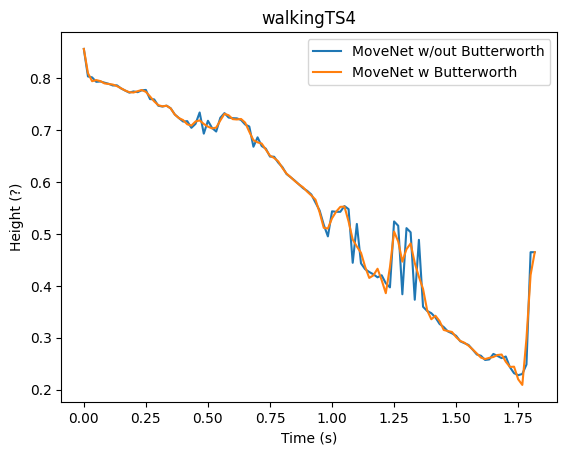

In [12]:
mean_abs_diffs = []
mv_knee_angles = []
trial_index = 2

try:
    mv_r_knee = movenet_outputs[trial_names[trial_index]]['right_knee'][:,1]
except:
    exit()

plt.plot(movenet_outputs[trial_names[trial_index]]['time'], mv_r_knee, label="MoveNet w/out Butterworth")
plt.xlabel("Time (s)")
plt.ylabel("Height (?)")
# plt.xlim(time_arrays[trial_index][0]+start_times[trial_index],time_arrays[trial_index][-1]+start_times[trial_index])
plt.title(trial_names[trial_index])

try:
    # mv_r_knee = exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_knee'][:,1], alpha=0.05)
    mv_r_knee = butterworth(movenet_outputs[trial_names[trial_index]]['right_knee'][:,1], cutoff=1.5, fs=5.0, order=5)
    # mv_r_knee = b_spline(movenet_outputs[trial_names[trial_index]]['right_knee'][:,1], k=100)
    # mv_r_knee = butterworth(exp_moving_average(movenet_outputs[trial_names[trial_index]]['right_knee'][:,1], alpha=0.5), cutoff=0.125, fs=5.0, order=5)
except:
    exit()

plt.plot(movenet_outputs[trial_names[trial_index]]['time'], mv_r_knee, label="MoveNet w Butterworth")

plt.legend()
plt.show()

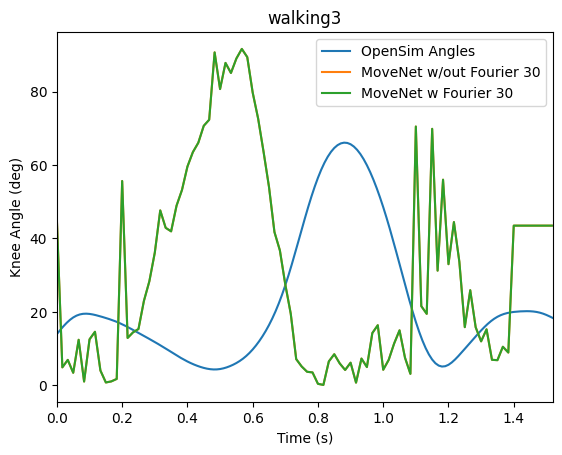

In [13]:
mean_abs_diffs = []
mv_knee_angles = []
trial_index = 1

try:
    mv_r_knee = movenet_outputs[trial_names[trial_index]]['right_knee']
except:
    exit()
mv_r_hip = movenet_outputs[trial_names[trial_index]]['right_hip']
mv_r_ankle = movenet_outputs[trial_names[trial_index]]['right_ankle']
cur_mv_knee_angles = []
for i in range(len(movenet_outputs[trial_names[trial_index]]['time'])):
    cur_mv_knee_angles.append(angle_from_center(mv_r_knee[i], mv_r_ankle[i], mv_r_hip[i], acute=False, deg=True))

# plt.plot(time_arrays[trial_index]+start_times[trial_index], knee_angles, label="Calculated Angles")
plt.plot(time_arrays[trial_index]+start_times[trial_index], coordinates['values'][trial_names[trial_index]]['knee_angle_r'], label="OpenSim Angles")
plt.plot(movenet_outputs[trial_names[trial_index]]['time'], cur_mv_knee_angles, label="MoveNet w/out Fourier 30")
plt.xlabel("Time (s)")
plt.ylabel("Knee Angle (deg)")
plt.xlim(time_arrays[trial_index][0]+start_times[trial_index],time_arrays[trial_index][-1]+start_times[trial_index])
plt.title(trial_names[trial_index])

try:
    mv_r_knee = fourier_smoothing(movenet_outputs[trial_names[trial_index]]['right_knee'], cutoff=100)
except:
    exit()
mv_r_hip = fourier_smoothing(movenet_outputs[trial_names[trial_index]]['right_hip'], cutoff=100)
mv_r_ankle = fourier_smoothing(movenet_outputs[trial_names[trial_index]]['right_ankle'], cutoff=100)
cur_mv_knee_angles = []
for i in range(len(movenet_outputs[trial_names[trial_index]]['time'])):
    cur_mv_knee_angles.append(angle_from_center(mv_r_knee[i], mv_r_ankle[i], mv_r_hip[i], acute=False, deg=True))

plt.plot(movenet_outputs[trial_names[trial_index]]['time'], cur_mv_knee_angles, label="MoveNet w Fourier 30")

plt.legend()
plt.show()